## Exploring and Understanding Time Series Modelling

This notebook is compiled from this blog http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

This demonstrates various time series analysis techniques and how to use them and an understanding of how the pieces fit together. Discuss why we use certain models vs others, or how these models build on each other's weaknesses.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

/Users/anindyas/anaconda/envs/timeseries/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, "%m-%d-%Y")

In [3]:
# raw adjusted close prices from '2015-01-01' to '2007-01-01' of 'SPY', 'TLT' and 'MSFT' stocks from yahoo.finance.com
data = pd.read_csv('data/yahoo-finance-stock.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)

In [4]:
data.head(5)

,SPY,TLT,MSFT
Date,,,
2007-01-03,113.757118,62.702785,23.203939
2007-01-04,113.998512,63.082920,23.165081
2007-01-05,113.089256,62.808407,23.032974
2007-01-08,113.612244,62.921005,23.258337
2007-01-09,113.515709,62.921005,23.281645


In [5]:
# log data
log_data = np.log(data/data.shift(1)).dropna()

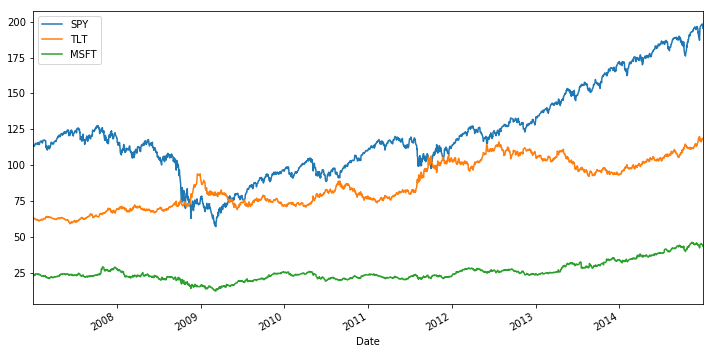

In [6]:
data.plot(figsize=(12, 6))

### Stationary Series

There are three basic criterion for a series to be classified as stationary series :

**Stationary Mean**
+ The mean of the series should not be a function of time rather should be a constant. The image below has the left hand graph satisfying the condition whereas the graph in red has a time dependent mean.

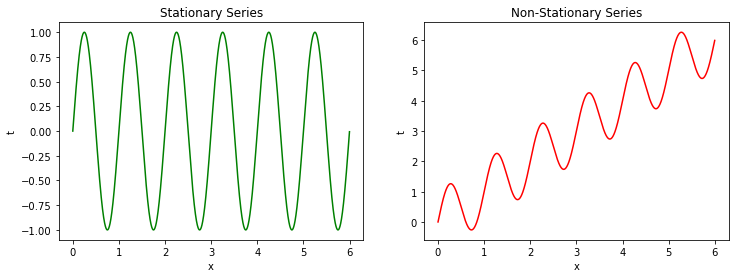

In [7]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
a = np.arange(0.0, 6.0, 0.001)
axes[0].plot(a, np.sin(2*np.pi*a), 'g')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].grid(False)
axes[0].set_title('Stationary Series')
axes[1].plot(a, np.sin(2*np.pi*a) + a, 'r')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].grid(False)
axes[1].set_title('Non-Stationary Series')

**Stationary Variance**
+ The variance of the series should not a be a function of time. This property is known as homoscedasticity. Following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right hand graph)

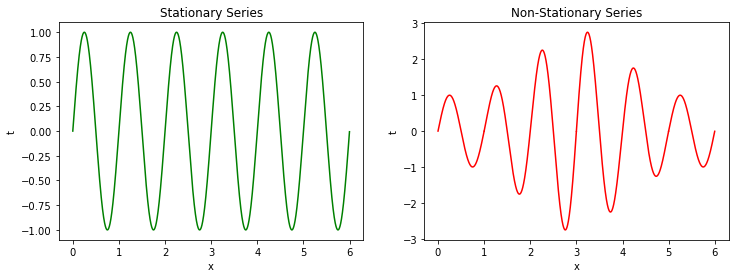

In [8]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
a0 = np.arange(0.0, 6.0, 0.001)
axes[0].plot(a0, np.sin(2*np.pi*a0), 'g')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].grid(False)
axes[0].set_title('Stationary Series')
a1 = np.arange(0.0, 1.0, 0.001)
b1 = np.arange(1.0, 3.0, 0.001)
c1 = np.arange(3.0, 5.0, 0.001)
d1 = np.arange(5.0, 6.0, 0.001)
axes[1].plot(a1, np.sin(2*np.pi*a1), 'r')
axes[1].plot(b1, b1 * np.sin(2*np.pi*b1), 'r')
axes[1].plot(c1, (6 - c1) * np.sin(2*np.pi*c1), 'r')
axes[1].plot(d1, np.sin(2*np.pi*d1), 'r')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].grid(False)
axes[1].set_title('Non-Stationary Series')

**Stationary Covariance**
+ The covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

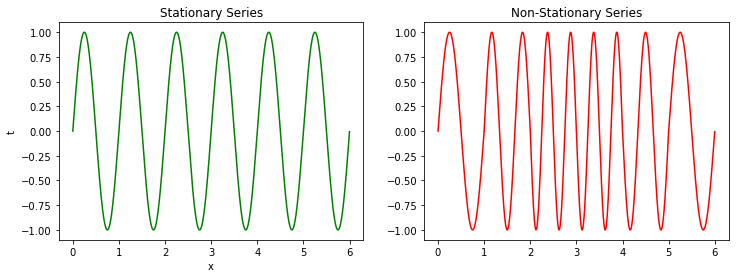

In [9]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
a0 = np.arange(0.0, 6.0, 0.001)
axes[0].plot(a0, np.sin(2*np.pi*a0), 'g')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].grid(False)
axes[0].set_title('Stationary Series')

a1 = np.arange(0.0, 1.0, 0.001)
b1 = np.arange(1.0, 2.0, 0.001)
c1 = np.arange(2.0, 3.0, 0.001)
d1 = np.arange(3.0, 4.0, 0.001)
e1 = np.arange(4.0, 5.0, 0.001)
f1 = np.arange(5.0, 6.0, 0.001)
axes[1].plot(a1, np.sin(2*np.pi*a1), 'r')
axes[1].plot(b1, -np.sin(2*np.pi*(1.5*b1)), 'r')
axes[1].plot(c1, -np.sin(2*np.pi*(2*c1)), 'r')
axes[1].plot(d1, -np.sin(2*np.pi*(2*d1)), 'r')
axes[1].plot(e1, -np.sin(2*np.pi*(1.5*e1)), 'r')
axes[1].plot(f1, np.sin(2*np.pi*f1), 'r')
axes[1].grid(False)
axes[1].set_title('Non-Stationary Series')

### Why do we care about 'stationarity' of a time series?

Until and unless our time series is stationary, we cannot build a time series model. In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try stochastic models to predict this time series. There are multiple ways of bringing this stationarity. Some of them are Detrending, Differencing etc.

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

*"For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables."*
(http://people.duke.edu/~rnau/411diff.htm)

With that said, **most TS we encounter in finance is NOT stationary**. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary.

### Serial Correlation (Autocorrelation)

Essentially when we model a time series we decompose the series into three components: trend, seasonal/cyclical, and random. The random component is called the residual or error. It is simply the difference between our predicted value(s) and the observed value(s). Serial correlation is when the residuals (errors) of our TS models are correlated with each other.

### Why Do We Care about Serial Correlation? 

We care about serial correlation because it is critical for the validity of our model predictions, and is intrinsically related to stationarity. Recall that the residuals (errors) of a stationary TS are serially uncorrelated by definition! If we fail to account for this in our models the standard errors of our coefficients are underestimated, inflating the size of our T-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True! **In layman's terms, ignoring autocorrelation means our model predictions will be bunk, and we're likely to draw incorrect conclusions about the impact of the independent variables in our model.**

In [10]:
# A convenience function for plotting the time series and analyzing the serial correlation visually. 
def tsplot(timeseries, lags=None, figsize=(16, 12), style='bmh'):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        timeseries.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(timeseries, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(timeseries, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(timeseries, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        
        #scs.probplot(timeseries, sparams=(timeseries.mean(), timeseries.std()), plot=pp_ax)

        pp_ax.hist(timeseries, normed=True, label='Hist')
        from scipy.stats import gaussian_kde, norm
        kde = gaussian_kde(timeseries)
        xlim = (-1.96*2, 1.96*2)
        x = np.linspace(xlim[0], xlim[1])
        pp_ax.plot(x, kde(x), label='KDE')
        pp_ax.plot(x, norm.pdf(x), label='N(0,1)')
        pp_ax.set_xlim(xlim)
        pp_ax.legend()
        pp_ax.set_title('Histogram plus estimated density')
        
        plt.tight_layout()
    return 

### 1. White Noise  Model

White noise is the first Time Series Model (TSM) we need to understand. By definition a time series that is a white noise process has serially Uncorrelated errors and the expected mean of those errors is equal to zero. Another description for serially uncorrelated errors is, independent and identically distributed (i.i.d.). This is important because, if our TSM is appropriate and successful at capturing the underlying process, the residuals of our model will be i.i.d. and resemble a white noise process. Therefore part of TSA is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and output the TS plot for visual inspection.

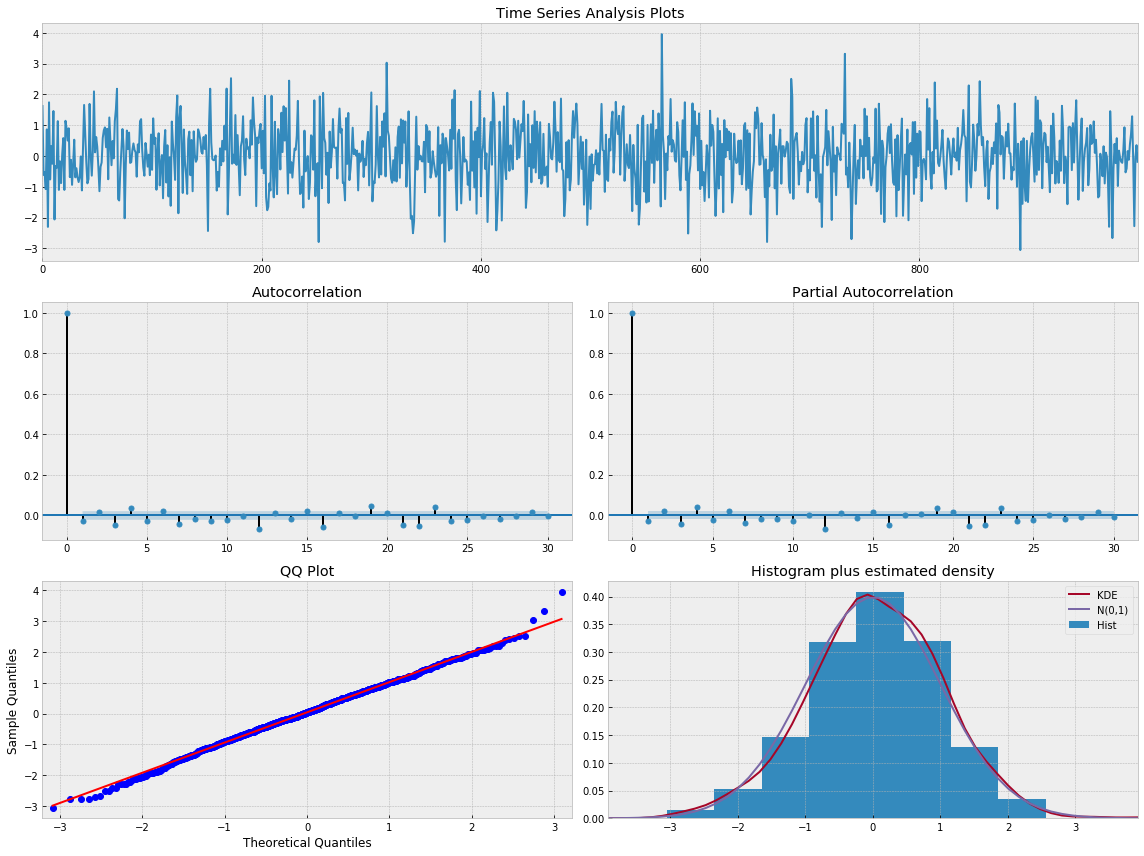

In [11]:
# generate white noise
np.random.seed(1)
# plot of discrete white noise
white_noise = np.random.normal(size=1000)
tsplot(white_noise, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

Let's see if we decompose the white noise into trend, seasonal/cyclical, and random components. White noise should not have any trend or seasonal component.

In [12]:
decomposition = sm.tsa.seasonal_decompose(white_noise, model='additive', freq=1)

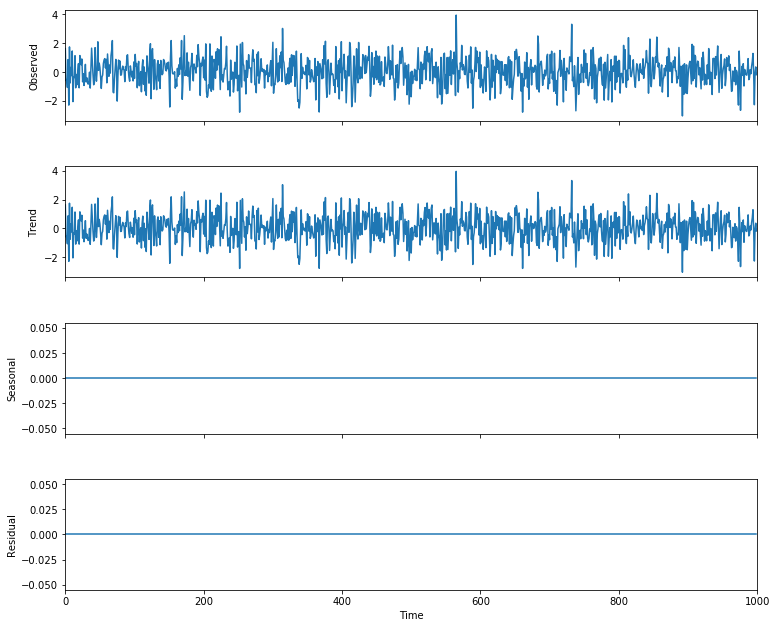

In [13]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
plt.show()

We can see clearly that the white noise does not depict any trend or seasonal component.

In [14]:
print("White noise / Random Series: [mean: {:.3f} | variance: {:.3f} | standard deviation: {:.3f}]"
.format(white_noise.mean(), white_noise.var(), white_noise.std()))

White noise / Random Series: [mean: 0.039 | variance: 0.962 | standard deviation: 0.981]


### 2. Random Walk Model

A random walk is a time series model $x_t$ such that $x_t = x_{t-1} + \omega_t$, where $\omega_t$ is a discreet white noise series.

The significance of a random walk is that it is **non-stationary** because the covariance between observations is time-dependent. If the **TS** we are modeling is a random walk it is unpredictable.

Let's simulate a random walk using the "numpy.random.normal(size=our_sample_size)" function to sample from the standard normal distribution. 

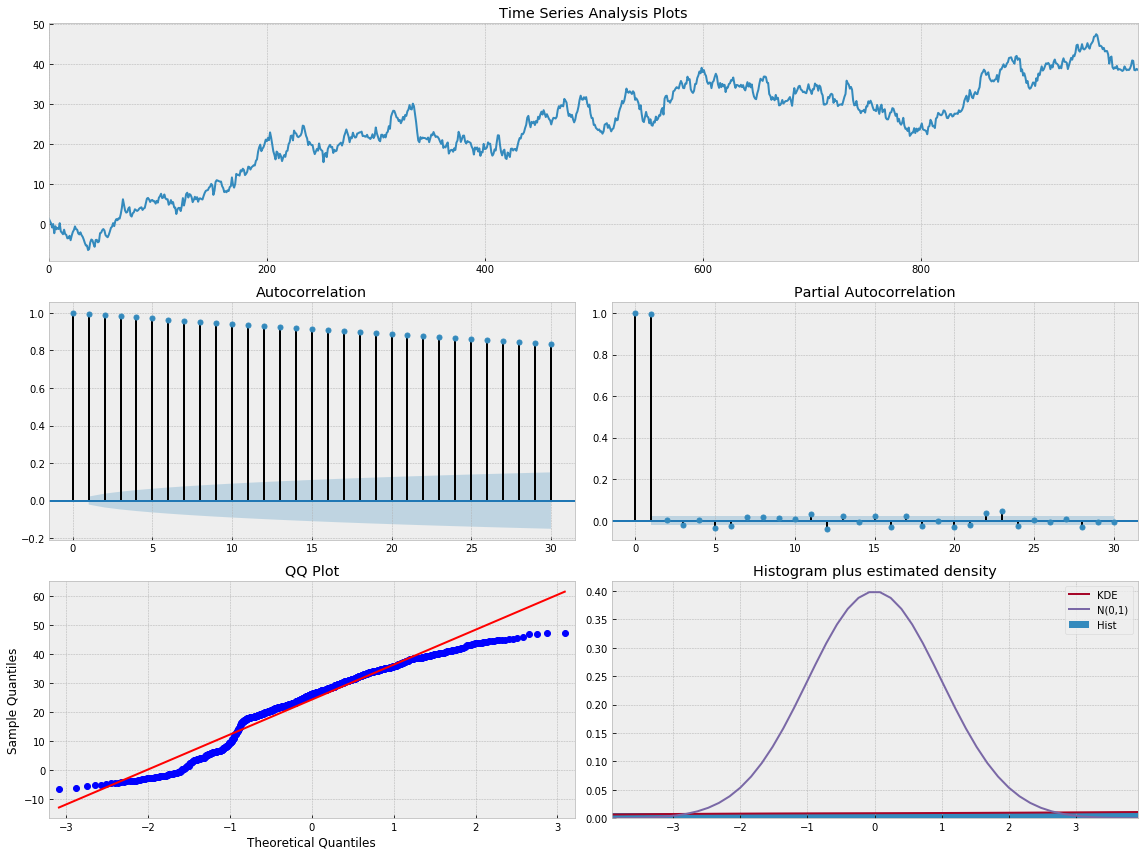

In [15]:
# Random walk without a drift
np.random.seed(1)
n_samples = 1000

random_walk = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    random_walk[t] = random_walk[t-1] + w[t]

tsplot(random_walk, lags=30)

Clearly our **TS** is not stationary.

Let's see if we decompose the random_walk into trend, seasonal/cyclical, and random components. they should not have any trend or seasonal component.

In [16]:
decomposition = sm.tsa.seasonal_decompose(random_walk, model='additive', freq=1)

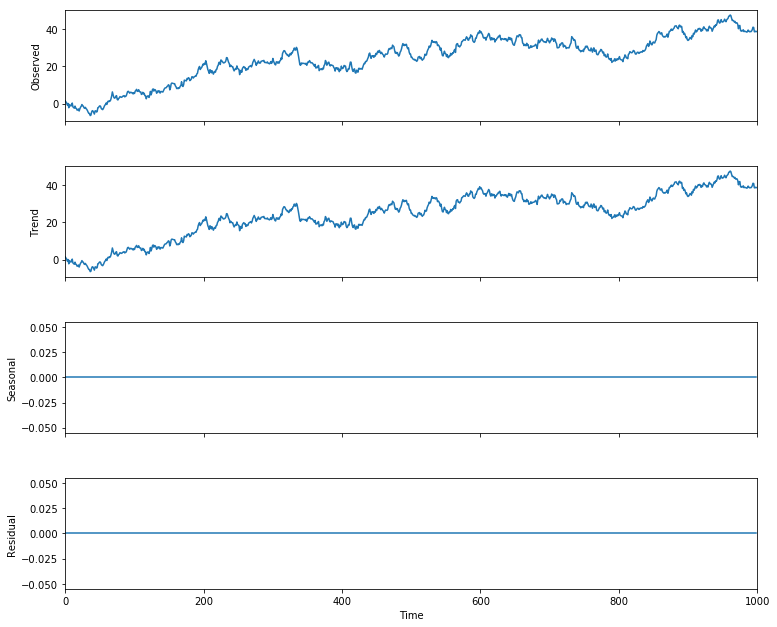

In [17]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(10)
plt.show()

We can see clearly that the white noise does not depict any trend or seasonal component.

Let's find out if the random walk model is a good fit for our simulated data. Recall that a random walk is $x_t = x_{t-1} + \omega_t$. Using algebra we can say that $x_t - x_{t-1} = \omega_t$. Thus the first differences of our random walk series should equal a white noise process! We can use the "np.diff()" function on our TS and see if this holds.

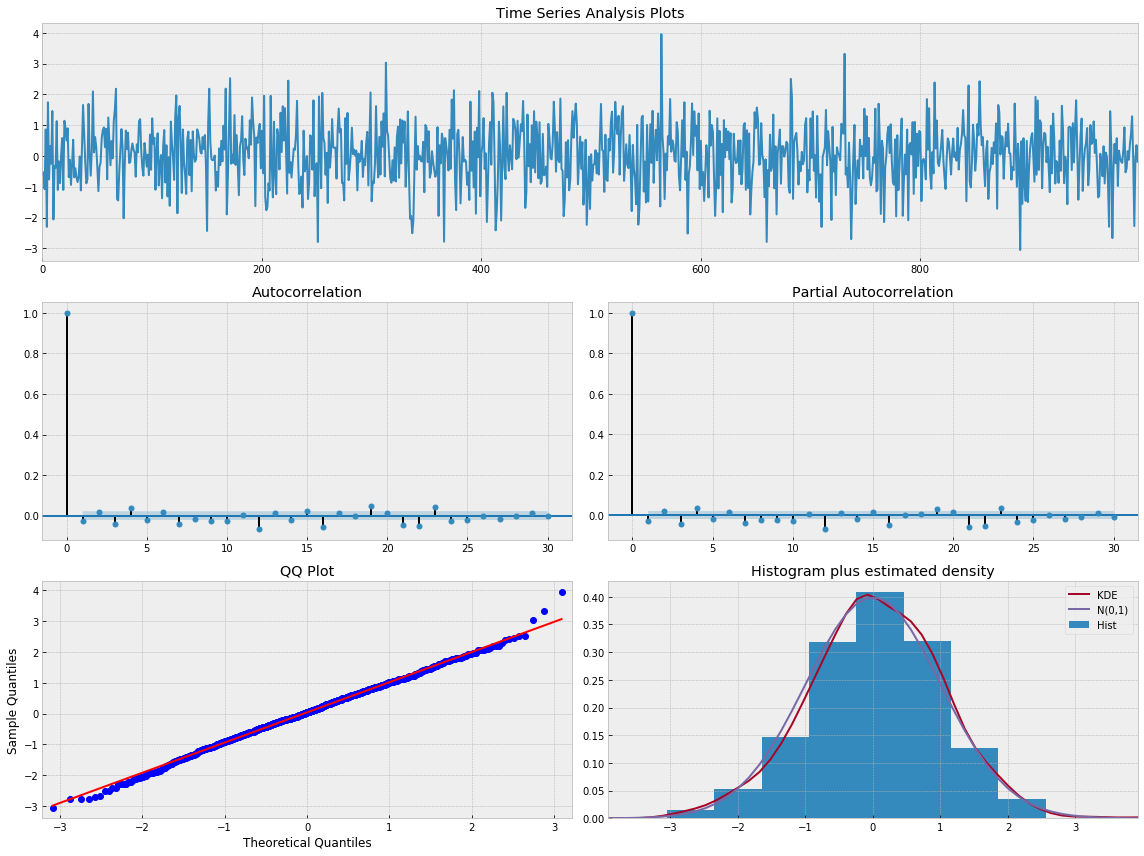

In [18]:
# First difference of simulated Random Walk series
tsplot(np.diff(random_walk), lags=30)

Our definition holds as this looks exactly like a white noise process. Let's find out if the random walk model is a good fit for our stock data. What if we fit a random walk to the first difference of SPY's prices?

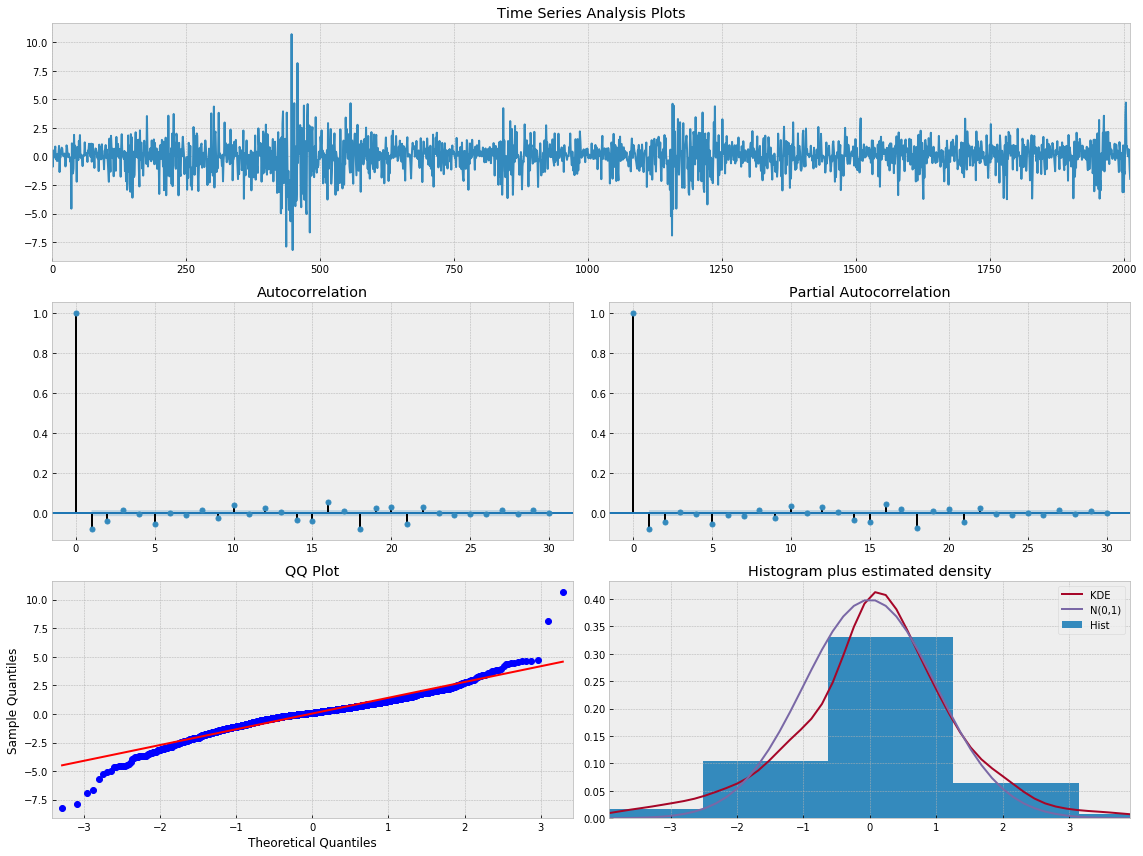

In [19]:
# First difference of SPY prices
tsplot(np.diff(data.SPY), lags=30)

Well, it's quite similar to white noise. However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with **'heavy tails'**. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

### 3. Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:

$y_t = \beta_0 + \beta_1t + \epsilon_t$

In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time. An example could be a company's sales that increase by the same amount at each time step.  Let's look at a contrived example below. In this simulation we assume Firm ABC sales regardless of time are -\$50.00 ($\beta_0$ or the intercept term) and +\$25.00 ($\beta_1$) at every time step. 

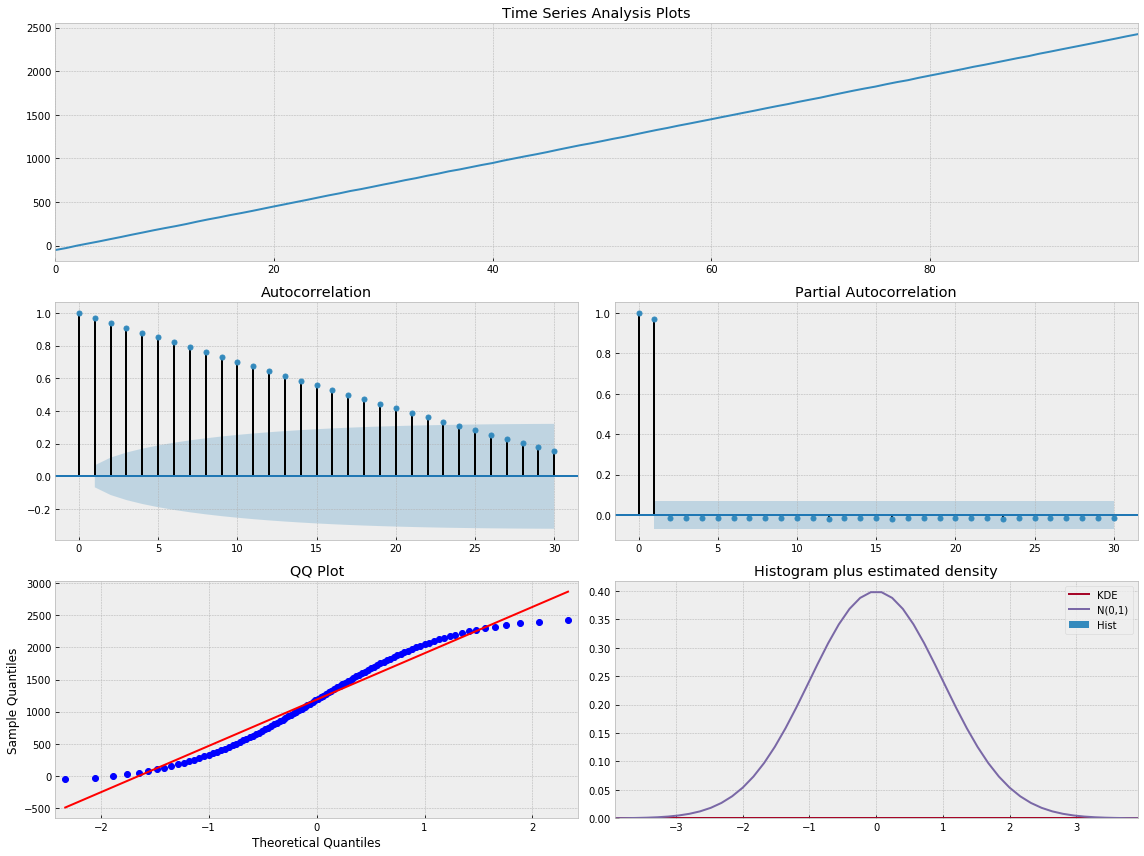

In [20]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.

for t in range(len(w)):
    y[t] = b0 + b1 * t + w[t]

tsplot(y, lags=30)

Here we can see that the residuals of the model are correlated and linearly decreasing as a function of the lag. The distribution is approximately normal. Before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. The significance of the PACF at lag 1 indicates that an *autoregressive* model may be appropriate.

### 4. Log-Linear Models

These models are similar to linear models except that the data points form an exponential function that represent a constant rate of change with respect to each time step. For example, firm ABC's sales increasing X% at each time step. When plotting the simulated sales data we get a curve that looks like this:

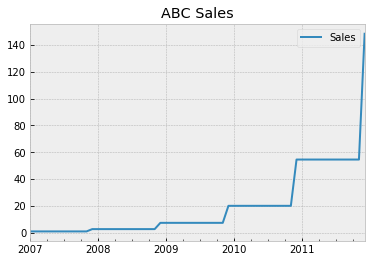

In [21]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx) + 1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

We can then transform the data by taking the natural logarithm of sales. Now a linear regression is a much better fit to the data.

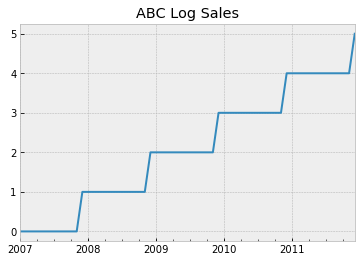

In [22]:
# ABC log sales 
with plt.style.context('bmh'):
    np.log(df['Sales']).plot()
    plt.title('ABC Log Sales')

These models have a fatal weakness as discussed previously. They assume serially Uncorrelated errors, which as we have seen in the linear model example is not true. In real life, TS data usually violates our stationary assumptions which motivates our progression to autoregressive models.

### 5. Autoregressive Models - AR(p)

When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. The formula looks like this:

\begin{equation*}
x_t = \alpha_1x_{t-1} + \ldots + \alpha_px_{t-p} + \omega_t \\
= \sum_{i=1}^P \alpha_i x_{t-i} + \omega_t
\end{equation*}

When we describe the **"order"** of the model, as in, an AR model of order **"p"**, the p represents the number of lagged variables used within the model. For example an AR(2) model or *second-order autoregressive model* looks like this:

\begin{equation*}
x_t = \alpha_1x_{t-1} + \alpha_2x_{t-2} + \omega_t
\end{equation*}

Here, alpha ($\alpha$) is the coefficient, and omega ($\omega$) is a white noise term. Alpha cannot equal zero in an AR model. Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary.

\begin{equation*}
x_t = 1x_{t-1} + \omega_t
\end{equation*}

Let's simulate an AR(1) model with alpha set equal to 0.6

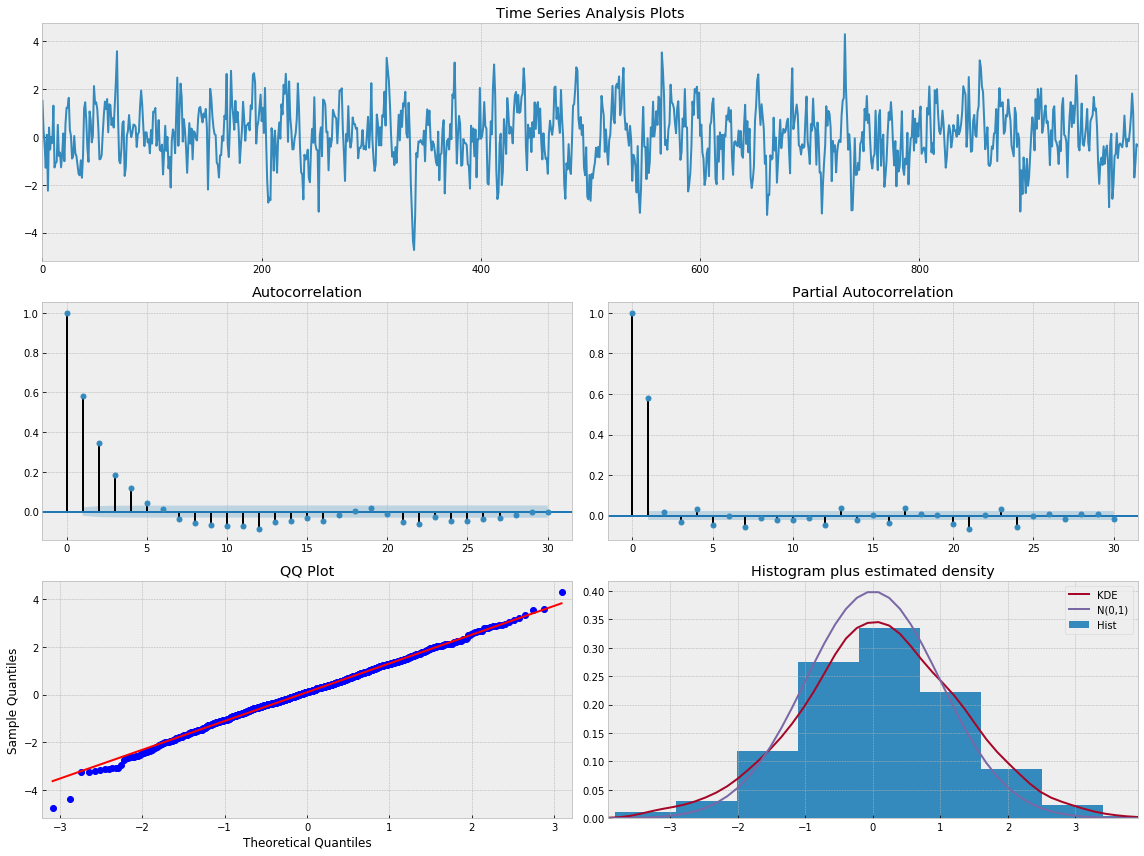

In [23]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t-1] + w[t]

tsplot(x, lags=30)

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function **"select_order()"** to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [24]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6
a = 0.6
model = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(model.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

CPU times: user 43.2 s, sys: 154 ms, total: 43.3 s
Wall time: 10.9 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data. Let's simulate an AR(2) process with $\alpha_1$ = 0.666 and $\alpha_2$ = -0.333. For this we make use of statsmodel's **"arma_generate_samples()"** function. This function allows us to simulate an AR model of arbitrary orders. Note that there are some peculiarities of Python's version which requires us to take some extra steps before using the function.

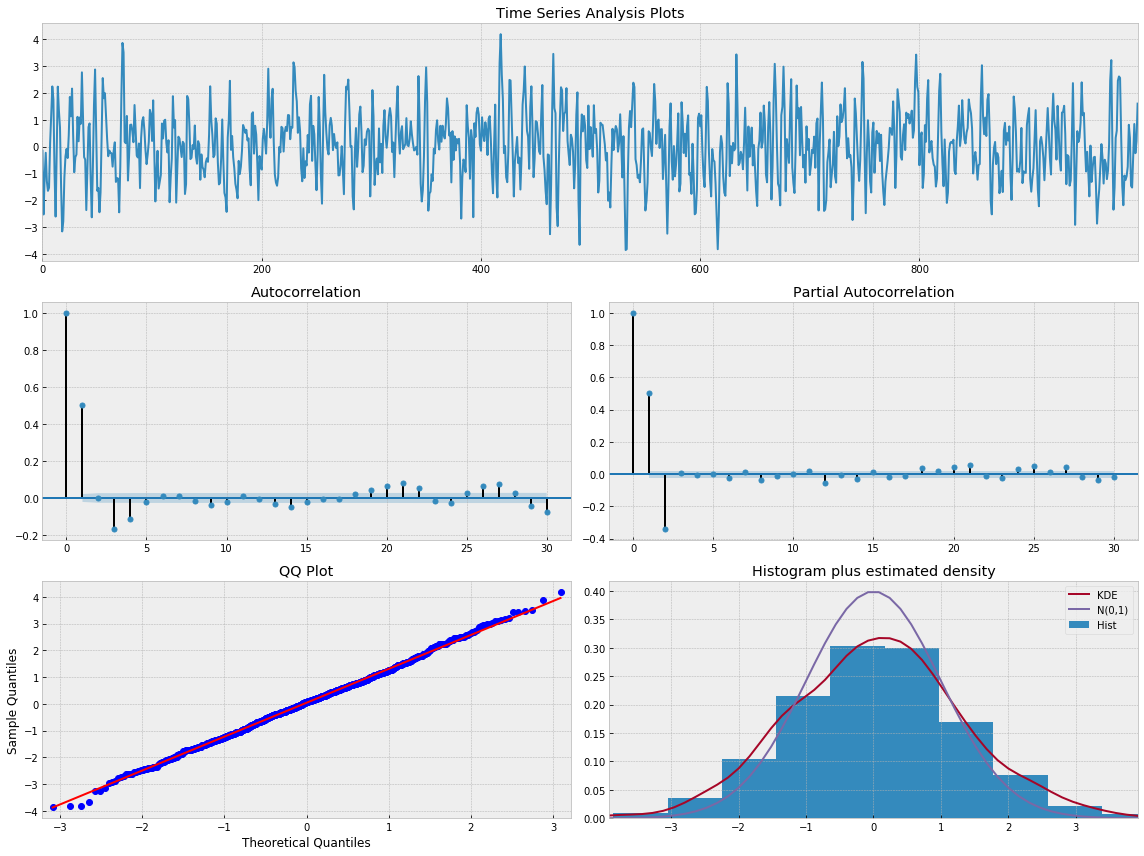

In [25]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Refer to the documentation and scroll down for example
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html
# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org

ar = np.r_[1, -alphas]  # add zero-lag and negate
ma = np.r_[1, betas] # add zero-lag

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 

tsplot(ar2, lags=30)

Let's see if we can recover the correct parameters.

In [26]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 30
model = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(model.params[0], model.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


Not bad. Let's see how the AR(p) model will fit MSFT log returns. Here is the return TS.

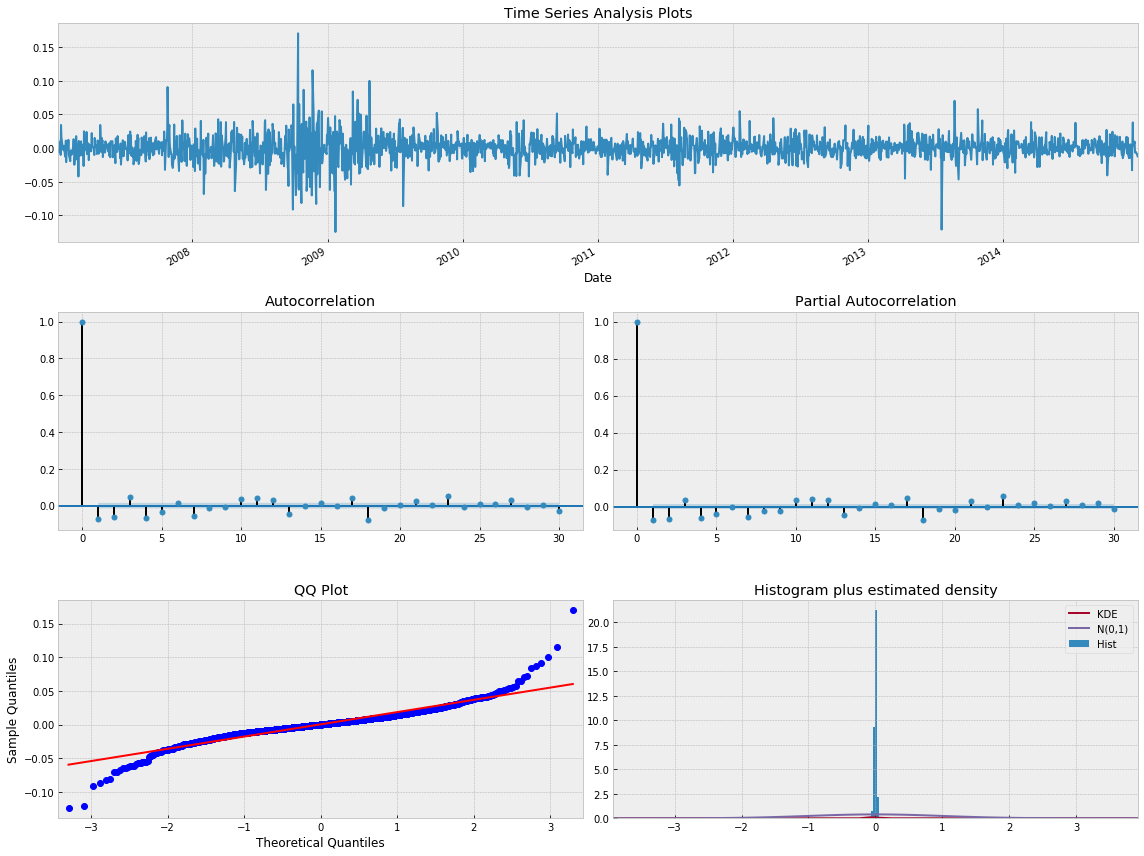

In [27]:
tsplot(log_data['MSFT'], lags=30)

In [28]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(log_data['MSFT']).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(log_data['MSFT']).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

best estimated lag order = 23


The best order is 23 lags or 23 parameters! Any model with this many parameters is unlikely to be useful in practice. Clearly there is more complexity underlying the returns process than this model can explain.

### 6. Moving Average Models - MA(q)

MA(q) models are very similar to AR(p) models. The difference is that the MA(q) model is a linear combination of past white noise error terms as opposed to a linear combination of past observations like the AR(p) model. The motivation for the MA model is that we can observe "shocks" in the error process directly by fitting a model to the error terms. In an AR(p) model these shocks are observed indirectly by using the ACF on the series of past observations. The formula for an MA(q) model is:

\begin{align}
x_t = \omega_t + \beta_1\omega_{t-1} + \ldots + \beta_q\omega_{t-q} + \\
= \omega_t + \sum_{i=1}^Q \beta_i \omega_{t-i} + 
\end{align}

Omega ($\omega$) is white noise with $\mathbf{E}(\omega_t) = 0$ and variance of sigma squared. Let's simulate this process using $\beta$ = 0.6 and specifying the AR(p) $\alpha$ = 0.

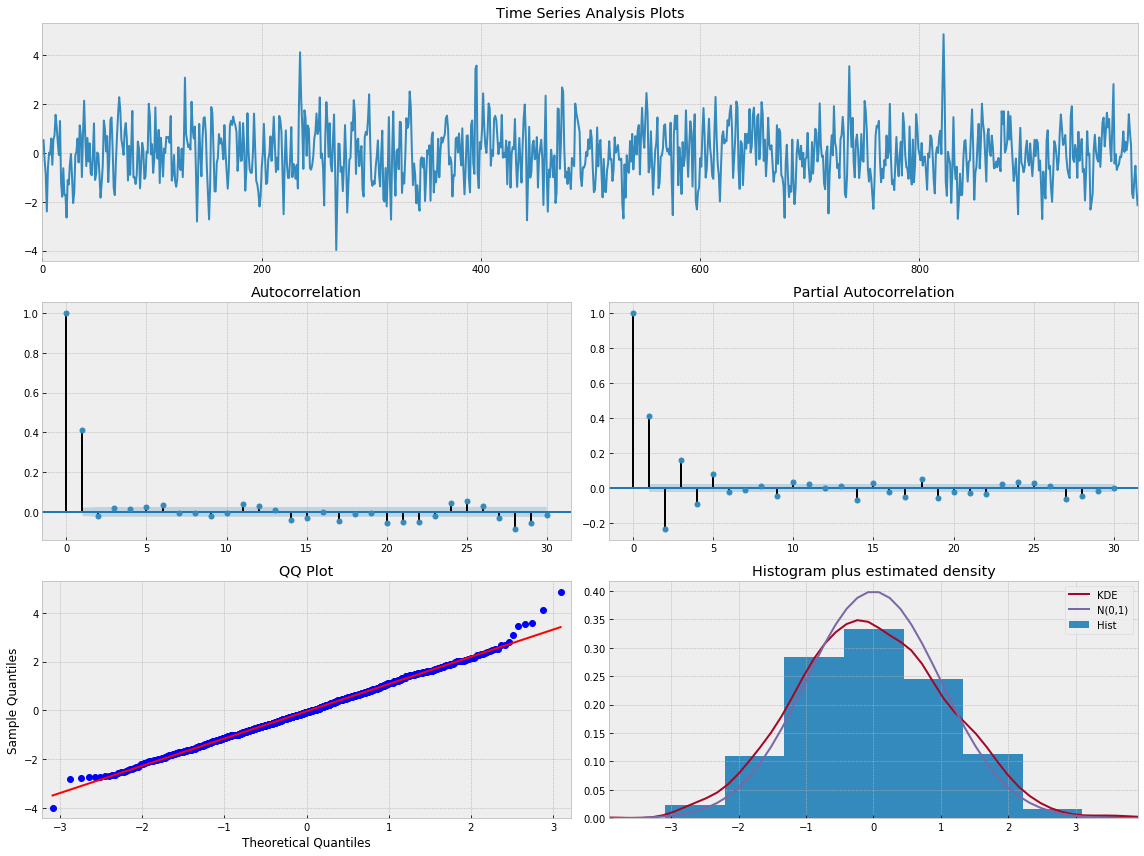

In [29]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ma1, lags=30)

The ACF function shows that lag 1 is significant which indicates that a MA(1) model may be appropriate for our simulated series. I'm not sure how to interpret the PACF showing significance at lags 2, 3, and 4 when the ACF only shows significance at lag 1. Regardless we can now attempt to fit a MA(1) model to our simulated data. We can use the same statsmodels **"ARMA()"** function specifying our chosen orders. We call on its **"fit()"** method to return the model output. 

In [30]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
model = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc') # there is no smt.MA(...) api like smt.AR(...)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Thu, 06 Jul 2017   AIC                           2785.025
Time:                        18:51:23   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                 Real           Imaginary           M

The model was able to correctly estimate the lag coefficent as 0.58 is close to our true value of 0.6. Also notice that our 95% confidence interval does contain the true value. 

Let's try simulating an MA(3)  process, then use our ARMA function to fit a third order MA model to the series and see if we can recover the correct lag coefficients (betas). Betas 1-3 are equal to 0.6, 0.4, and 0.2 respectively.

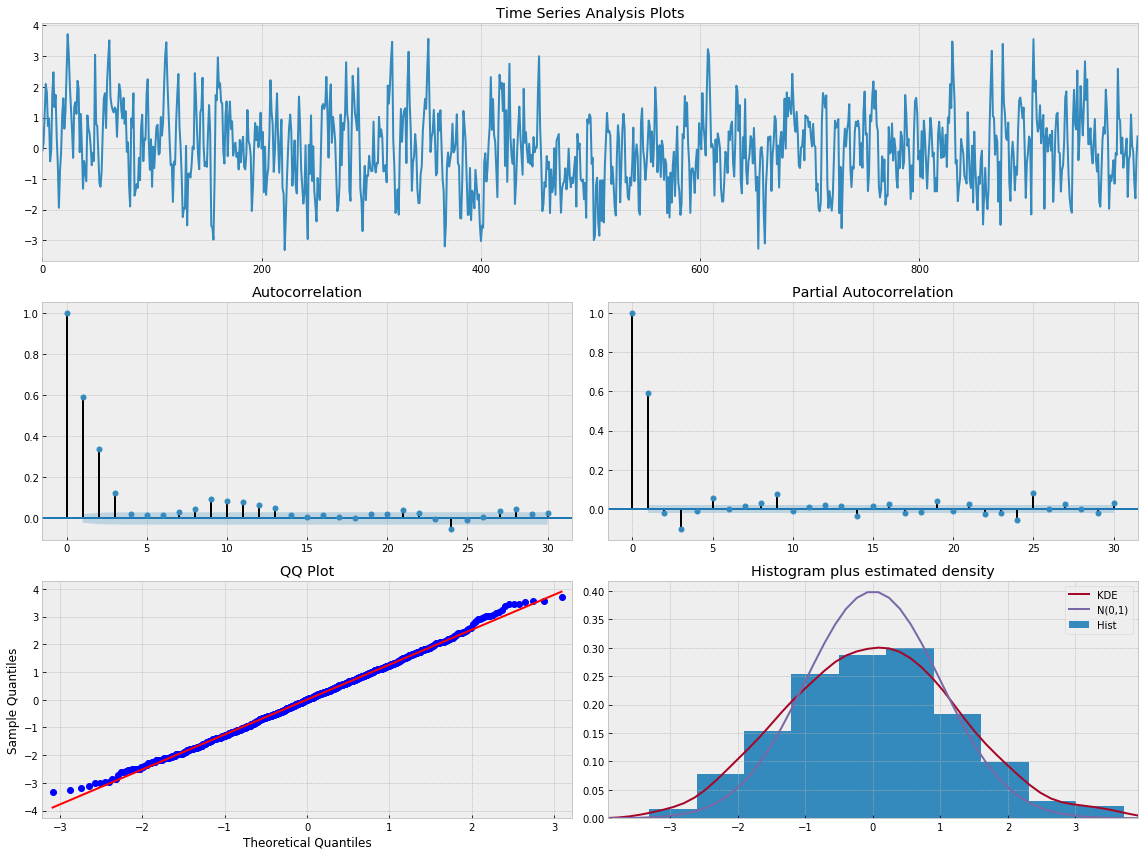

In [31]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)

In [32]:
# Fit MA(3) model to simulated time series

max_lag = 30
model = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Thu, 06 Jul 2017   AIC                           2862.075
Time:                        18:51:24   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

The model was able to estimate the real coefficients effectively. Our 95% confidence intervals also contain the true parameter values of 0.6, 0.4, and 0.3. 

Now let's try fitting an MA(3) model to the SPY's log returns. Keep in mind we do not know the true parameter values.

In [33]:
# Fit MA(3) to SPY returns

max_lag = 30
model = smt.ARMA(log_data['SPY'], order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.952
Method:                           mle   S.D. of innovations              0.014
Date:                Thu, 06 Jul 2017   AIC                         -11505.905
Time:                        18:51:24   BIC                         -11483.475
Sample:                    01-04-2007   HQIC                        -11497.672
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

Let's look at the model residuals.

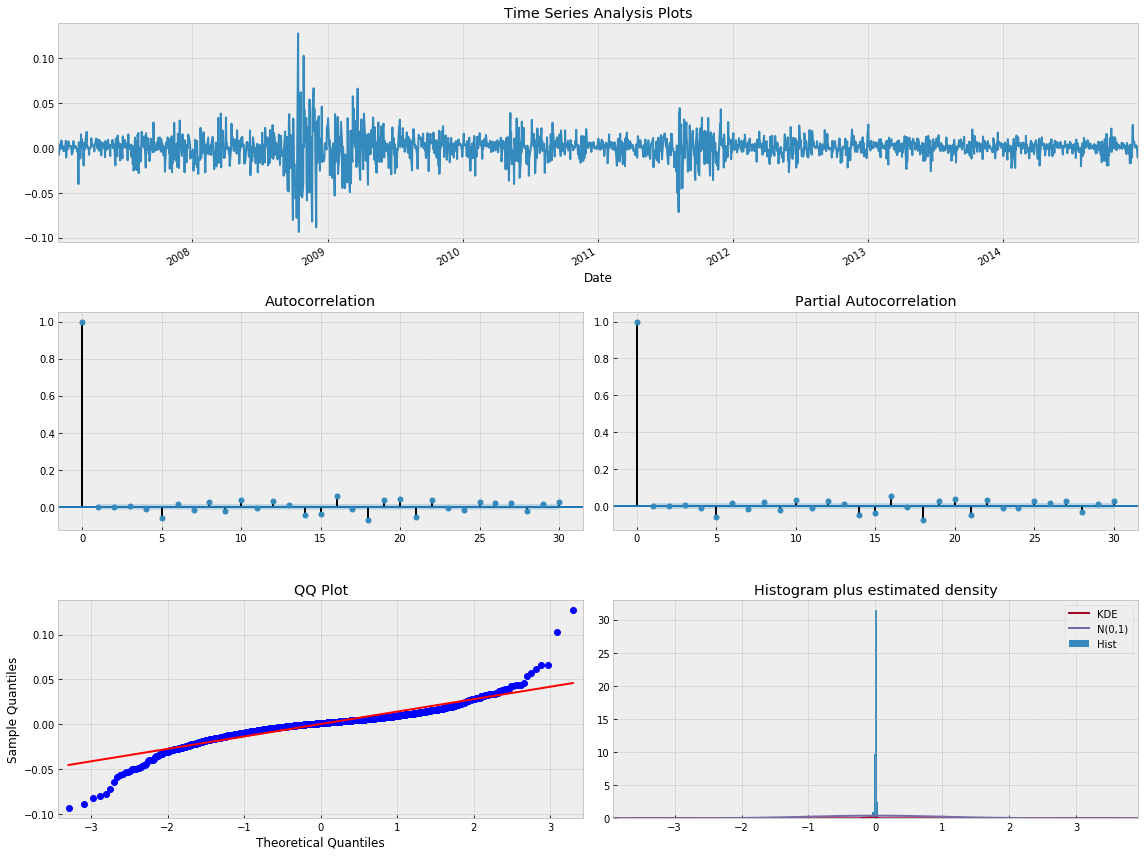

In [34]:
tsplot(model.resid, lags=max_lag)

Not bad. Some of the ACF lags concern me especially at 5, 16, and 18. It could be sampling error but that combined with the heaviness of the tails makes me think this isn't the best model to predict future SPY returns.

### 7. Autoregressive Moving Average Models - ARMA(p, q)

As you may have guessed, the ARMA model is simply the merger between AR(p) and MA(q) models. Let's recap what these models represent to us from a quant finance perspective: 

+ AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets. 
+ MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

*"For a set of products in a grocery store, the number of active coupon campaigns introduced at different times would constitute multiple 'shocks' that affect the prices of the products in question."*

[AM207: Pavlos Protopapas, Harvard University](http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html)

ARMA's weakness is that it ignores the *volatility clustering* effects found in most financial time series. 

The model formula is:

\begin{equation*}
x_t = \alpha_1x_{t-1} + \alpha_2x_{t-2} + \ldots + \alpha_px_{t-p} + \omega_t + \beta_1\omega_{t-1} + \beta_2\omega_{t-2} + \ldots + \beta_q\omega_{t-q} \\
= \sum_{i=1}^P \alpha_i x_{t-i} + \omega_t + \sum_{i=1}^Q \beta_i \omega_{t-i}
\end{equation*}

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3]. 

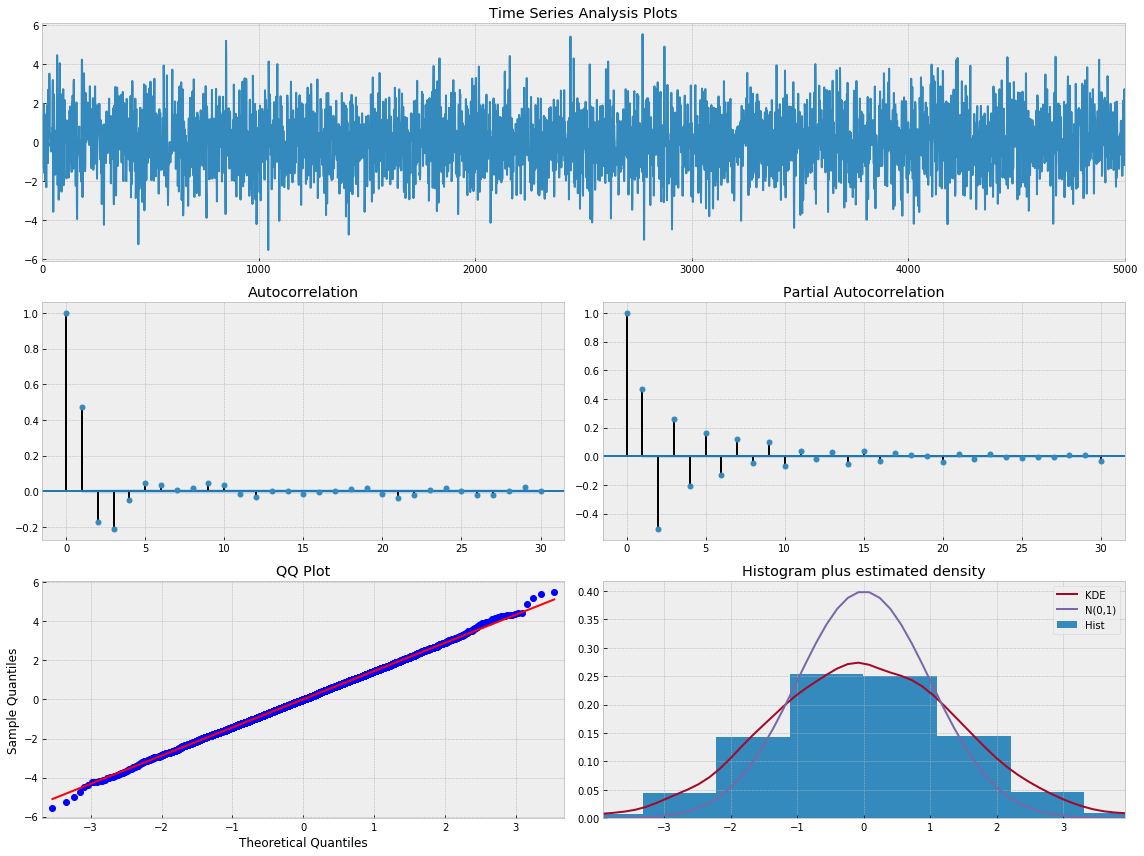

In [35]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

In [36]:
# Fit ARMA(2, 2) model to simulated time series
model = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Thu, 06 Jul 2017   AIC                          14162.352
Time:                        18:51:27   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

The model has correctly recovered our parameters, and our true parameters are contained within the 95% confidence interval.

Next we simulate a ARMA(3, 2) model. After, we cycle through a non trivial number of combinations of p, q to fit an ARMA model to our simulated series. We choose the best combination based on which model produces the lowest Akaike Information Criterion (AIC).

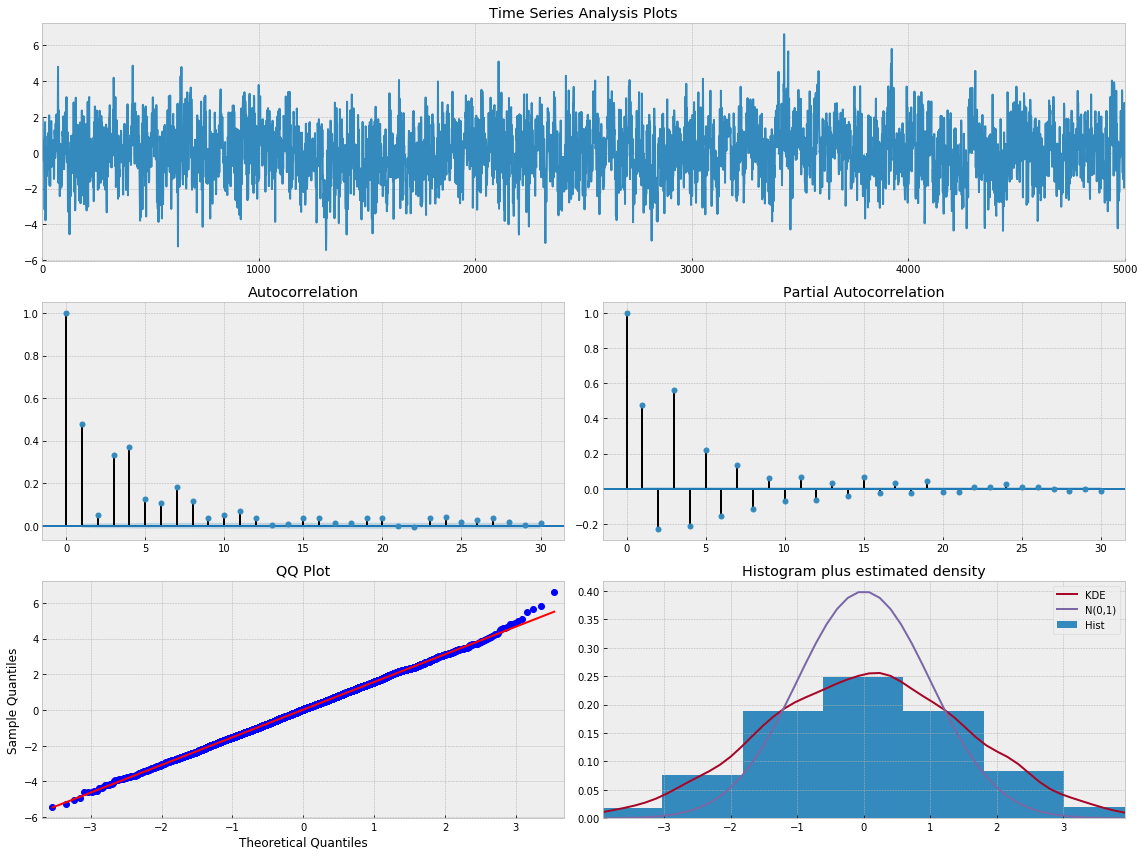

In [37]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

Above we see the output of our simulated time series before any model fitting. We do the model fitting below.

In [38]:
import warnings
import itertools

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Define the p and q parameters to take any value between 0 and 5
p = q = range(0, 5)

# Generate all different combinations of p and q
pq = list(itertools.product(p, q))

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_model = None
temp_model = None

for (i, j) in pq:

    try:
        temp_model = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
        if temp_model.aic < best_aic:
            best_aic = temp_model.aic
            best_order = (i, j)
            best_model = temp_model
    except: 
        continue
        
print("Best ARMA Model: ARMA{} - AIC:{:6.5f}".format(best_order, best_aic))
# Best ARMA Model: ARMA(3, 2) - AIC:14212.01026

Best ARMA Model: ARMA(3, 2) - AIC:14212.01026


The correct order was recovered above.

In [39]:
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7100.005
Method:                           mle   S.D. of innovations              1.001
Date:                Thu, 06 Jul 2017   AIC                          14212.010
Time:                        18:51:42   BIC                          14251.113
Sample:                             0   HQIC                         14225.715
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5254      0.027     19.388      0.000       0.472       0.579
ar.L2.y       -0.2634      0.016    -16.458      0.000      -0.295      -0.232
ar.L3.y        0.4307      0.014     31.615      0.0

We see that the correct order was selected and the model correctly estimated our parameters. However notice the AR.L2.y and  AR.L3.y coefficents; their true values of -0.25 and 0.4 respectively are almost outside of the 95% confidence interval!

Below we observe the model's residuals. Clearly it is a white noise process, thus the best model has been fit to *explain* the data.

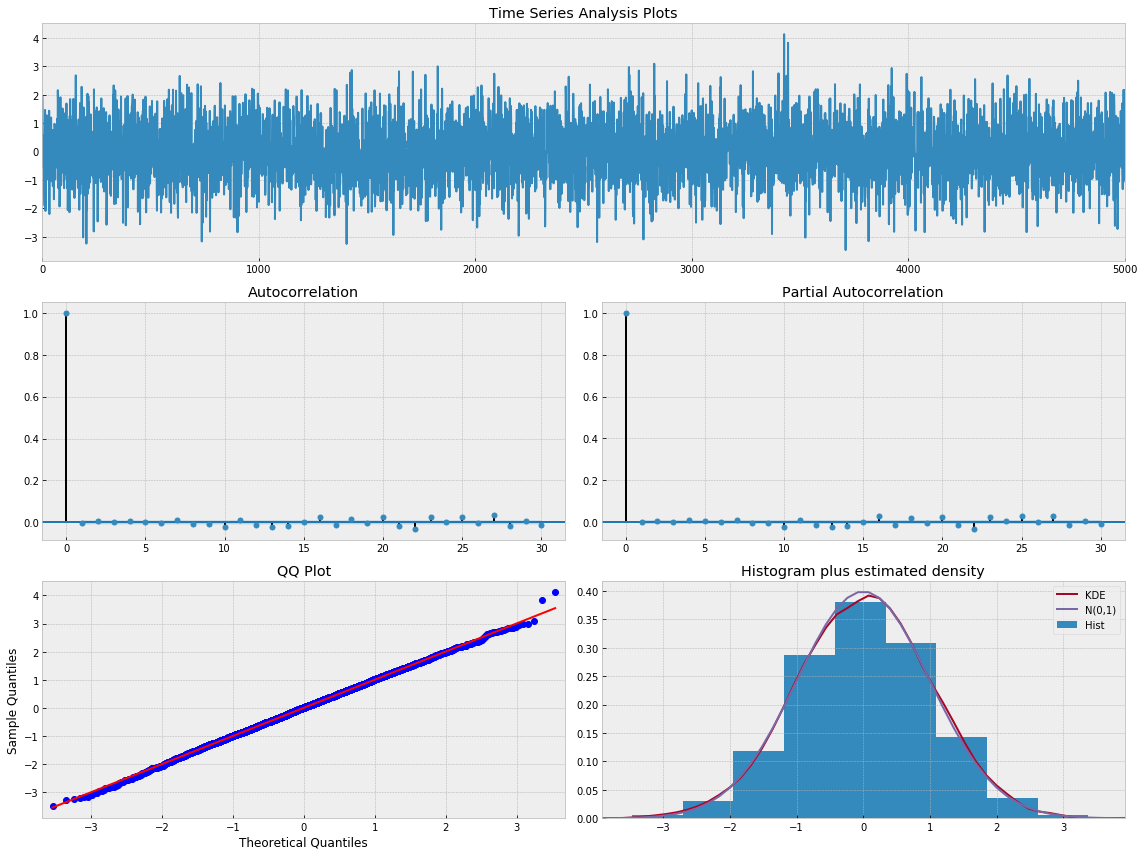

In [40]:
tsplot(best_model.resid, lags=30)

Next we fit an ARMA model to SPY returns. The plot below is the time series before model fitting.

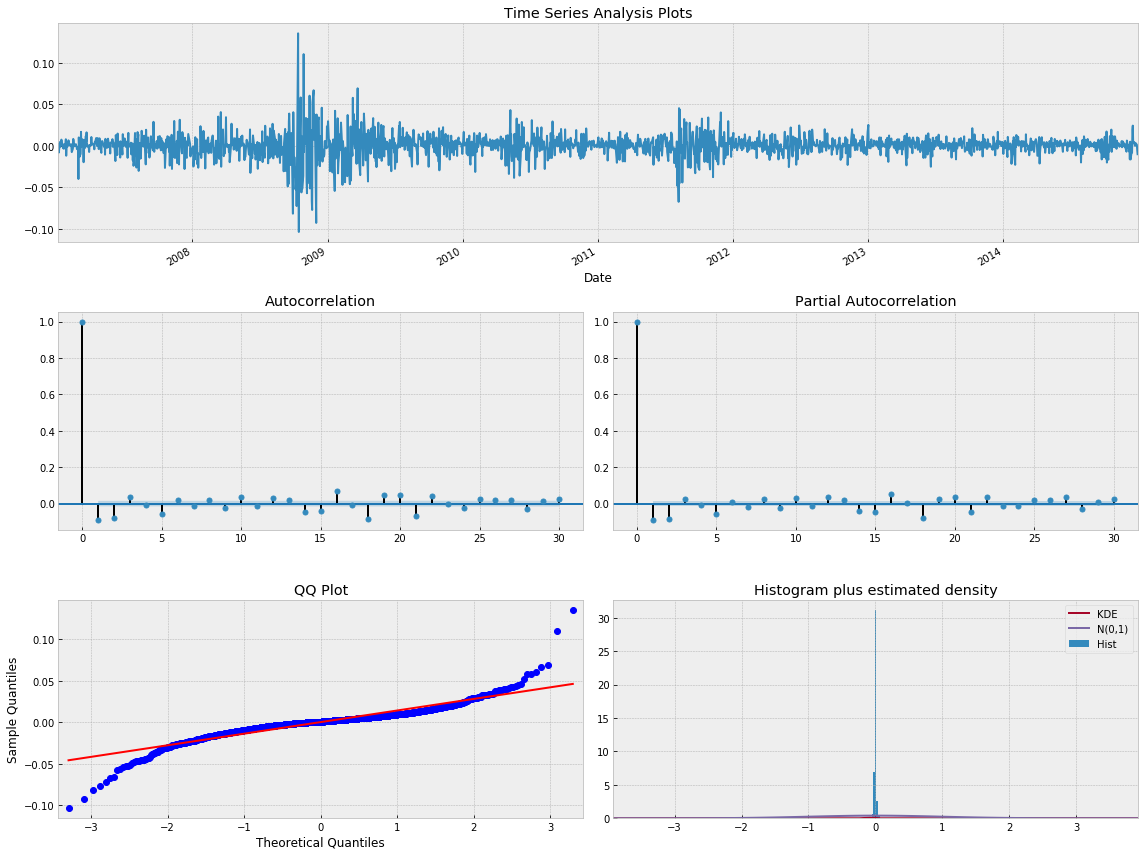

In [41]:
tsplot(log_data['SPY'], lags=30)

In [42]:
import warnings
import itertools

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Define the p and q parameters to take any value between 0 and 5
p_rng = q_rng = range(5)

# Generate all different combinations of p and q
pq = list(itertools.product(p_rng, q_rng))

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_model = None
temp_model = None

for (p, q) in pq:

    try:
        temp_model = smt.ARMA(log_data['SPY'], order=(p, q)).fit(method='mle', trend='nc')
        if temp_model.aic < best_aic:
            best_aic = temp_model.aic
            best_order = (p, q)
            best_model = temp_model
    except: 
        continue
        
print("Best ARMA Model: ARMA{} - AIC:{:6.5f}".format(best_order, best_aic))
# Best ARMA Model: ARMA(4, 4) - AIC:-11518.23123

Best ARMA Model: ARMA(4, 3) - AIC:-11519.19687


We plot the model residuals.

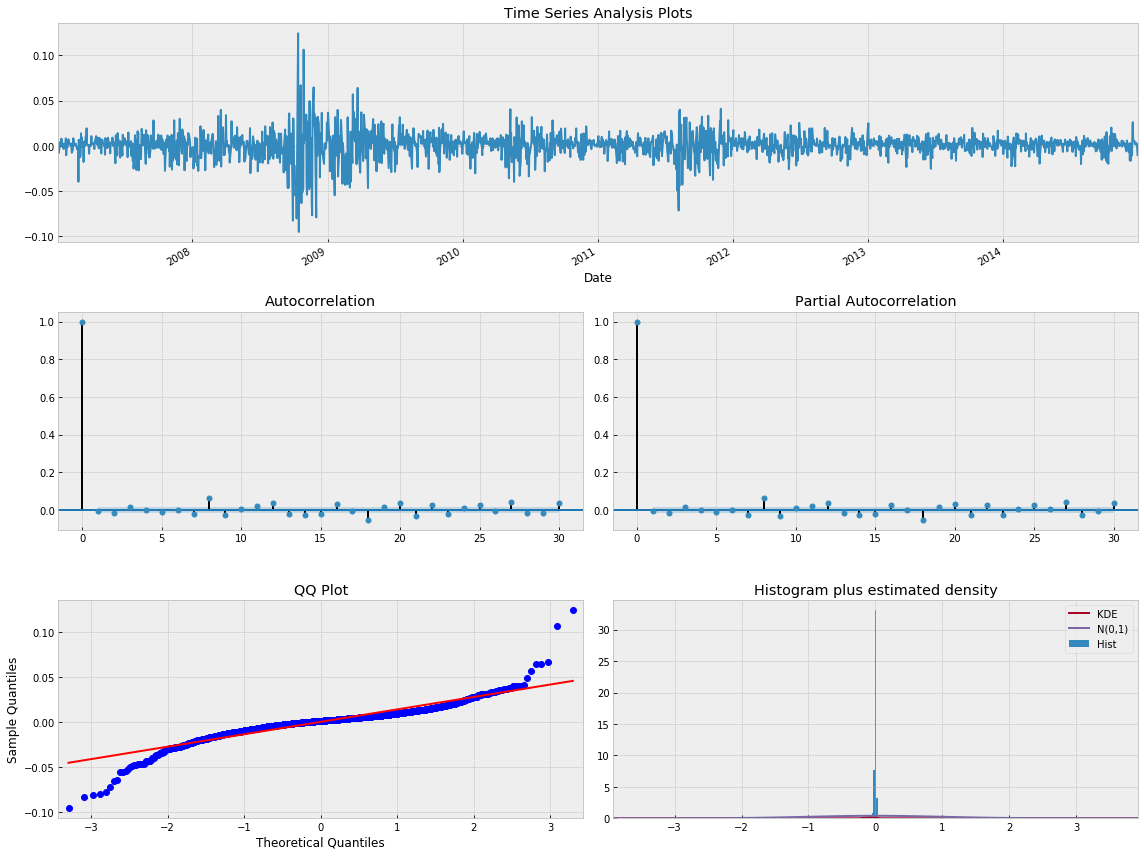

In [43]:
tsplot(best_model.resid, lags=30)

The ACF and PACF are showing no significant autocorrelation. The QQ and Probability Plots show the residuals are approximately normal with heavy tails. However, this model's residuals do NOT look like white noise! Look at the jagged areas (near 2012 and 2009) of obvious conditional heteroskedasticity (*conditional volatility*) that the model has not captured. 

### 8. Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

**ARIMA** is a natural extension to the class of ARMA models. As previously mentioned many of our TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of a Guassian random walk and proved that it equals white noise. Said another way, we took the nonstationary random walk and transformed it to stationary white noise by first-differencing.

Without diving too deeply into the equation, just know the **"d"** references the number of times we are differencing the series. A side note, in Python we must use **np.diff()** function if we need to difference a series more than once. The **pandas** functions **DataFrame.diff()/Series.diff() only takes the first difference of a dataframe/series and does not implement the recursive differencing needed in TSA.**

In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPY returns. We use the AIC to evaluate each model. The lowest AIC wins. 

In [44]:
import warnings
import itertools

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Define the p and q parameters to take any value between 0 and 5
p_rng = q_rng = range(5)

# Define the d parameter to take any value between 0 and 2
d_rng = range(2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p_rng, d_rng, q_rng))

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_model = None
temp_model = None

for (p, d, q) in pdq:

    try:
        temp_model = smt.ARIMA(log_data['SPY'], order=(p,d,q)).fit(method='mle', trend='nc')
        if temp_model.aic < best_aic:
            best_aic = temp_model.aic
            best_order = (p, d, q)
            best_model = temp_model
    except: 
        continue

print("Best ARMA Model: ARMA{} - AIC:{:6.5f}".format(best_order, best_aic))
# Best ARMA Model: ARMA(4, 0, 4) - AIC:-11518.23123

Best ARMA Model: ARMA(4, 0, 3) - AIC:-11519.19687


It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. Below, we plot the model residuals. The result is essentially identical to the ARMA(4, 4) model we fit above. Clearly this ARIMA model has not explained the conditional volatility in the series either! 

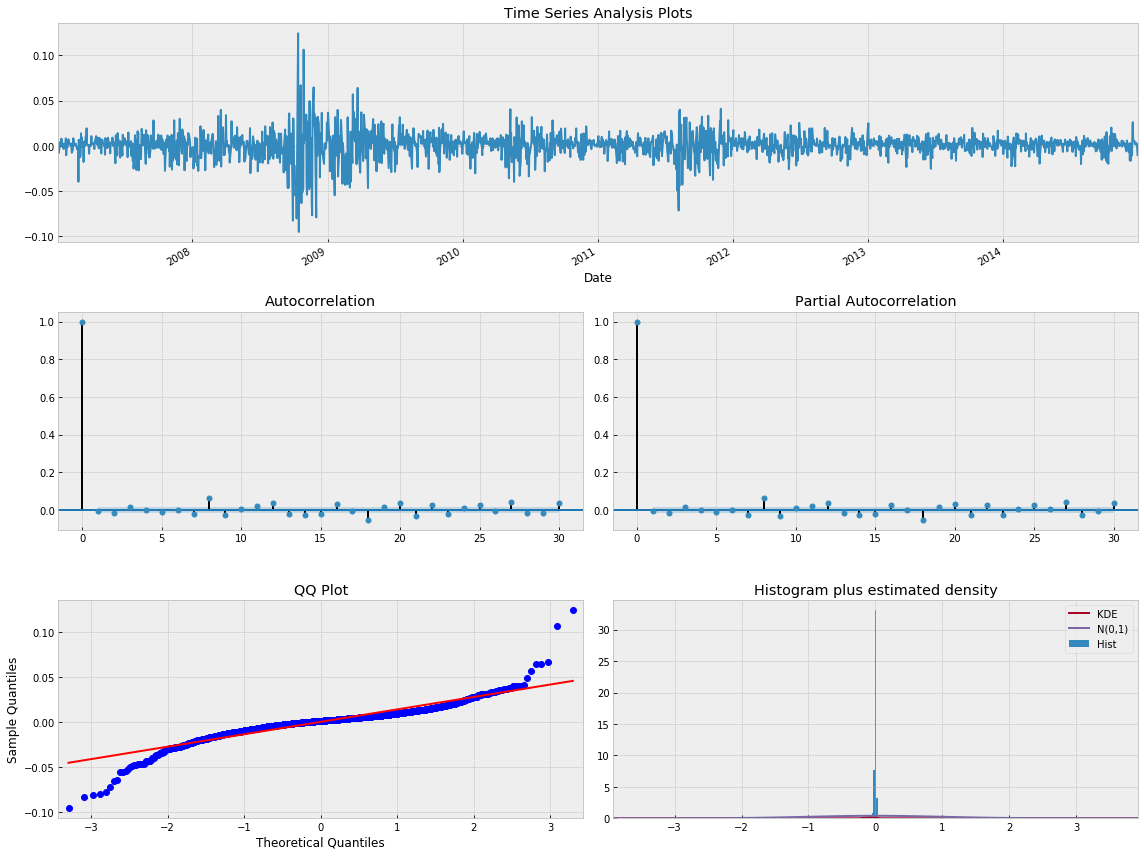

In [45]:
# ARIMA model resid plot
tsplot(best_model.resid, lags=30)

Now we have at least accumulated enough knowledge to make a simple forecast of future returns. Here we make use of our model's **forecast()** method. As arguments, it takes an integer for the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [46]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_model.forecast(steps=n_steps, alpha=0.05) # 95% CI, The confidence intervals for the forecasts are (1 - alpha) %
_, err99, ci99 = best_model.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001131,-0.025887,-0.034377,0.028149,0.036638
2015-01-01,-0.000125,-0.027251,-0.035775,0.027002,0.035525
2015-01-02,0.000143,-0.027020,-0.035556,0.027306,0.035841
2015-01-03,0.000588,-0.026576,-0.035111,0.027751,0.036286
2015-01-04,-0.000194,-0.027360,-0.035896,0.026972,0.035508


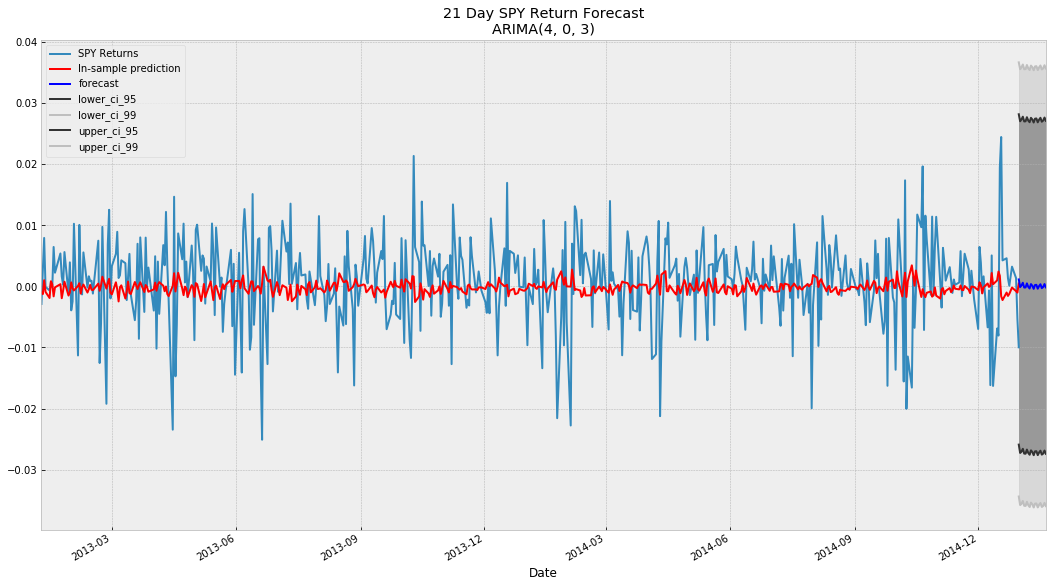

In [47]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(18,10))
ax = plt.gca()

ts = log_data['SPY'].iloc[-500:].copy()
ts.plot(ax=ax, label='SPY Returns')
# in sample prediction
pred = best_model.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)